# Python Spark Logistic Regression example

### 1. Set up spark context and SparkSession

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
          .appName("Python Spark Logistic Regression example") \
          .config("spark.some.config.option", "some-value") \
          .getOrCreate()

### 2. Load dataset

In [2]:
df = spark.read.format('com.databricks.spark.csv') \
            .options(header='true', inferschema='true') \
            .load("../data/bank.csv",header=True);
df.drop('day','month','poutcome').show(5)

+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular|      79|       1|   -1|       0| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular|     220|       1|  339|       4| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular|     185|       1|  330|       1| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|     199|       4|   -1|       0| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|     226|       1|   -1|       0| no|
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
o

In [3]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [4]:
df.count()

4521

In [5]:
df.distinct().count()

4521

In [6]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):
    
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol())) 
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] 
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)
    
    data = data.withColumn('label',col(labelCol))
    
    return data.select('features','label')

### 3. Deal with categorical data and Convert the data to dense vector

In [7]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome']

num_cols = ['balance', 'duration','campaign','pdays','previous',]
labelCol = 'y'

from pyspark.sql.functions import col

data = get_dummy(df,catcols,num_cols,labelCol)

In [8]:
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[8,11,15,16,1...|   no|
|(29,[4,11,13,16,1...|   no|
|(29,[0,12,14,16,1...|   no|
|(29,[0,11,14,16,1...|   no|
|(29,[1,11,13,16,1...|   no|
+--------------------+-----+
only showing top 5 rows



### 4. Deal with Categorical Label and Variables

In [9]:
from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(29,[8,11,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
|(29,[0,12,14,16,1...|   no|         0.0|
|(29,[0,11,14,16,1...|   no|         0.0|
|(29,[1,11,13,16,1...|   no|         0.0|
+--------------------+-----+------------+
only showing top 5 rows



In [10]:
from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(29,[8,11,15,16,1...|   no|(29,[8,11,15,16,1...|
|(29,[4,11,13,16,1...|   no|(29,[4,11,13,16,1...|
|(29,[0,12,14,16,1...|   no|(29,[0,12,14,16,1...|
|(29,[0,11,14,16,1...|   no|(29,[0,11,14,16,1...|
|(29,[1,11,13,16,1...|   no|(29,[1,11,13,16,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



### 5. Split the data to training and test data sets

In [11]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])
trainingData.show(5,False)
testData.show(5,False)

+------------------------------------------------------------------------------------------------+-----+
|features                                                                                        |label|
+------------------------------------------------------------------------------------------------+-----+
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-588.0,81.0,4.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,104.0,3.0,-1.0]) |no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,238.0,808.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,466.0,164.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,644.0,54.0,2.0,-1.0]) |no   |
+------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+-----------------------------

### 6. Fit Logistic Regression Model

In [12]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

### 7. Pipeline Architecture

In [13]:
# !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [14]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

In [15]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

### 8. Make predictions

In [16]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



### 9. Evaluation

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.101741


### 10. visualization

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

['no', 'yes']

In [20]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[1591,   37],
       [ 150,   60]])

Confusion matrix, without normalization
[[1591   37]
 [ 150   60]]


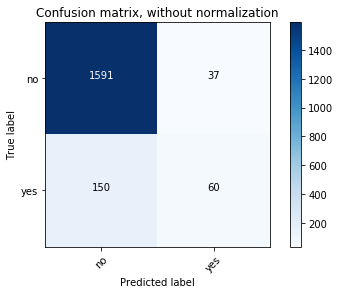

In [21]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[ 0.97727273  0.02272727]
 [ 0.71428571  0.28571429]]


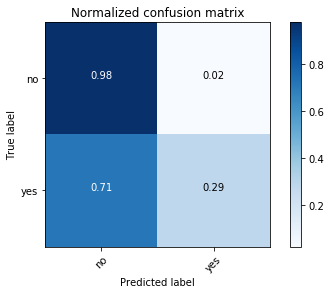

In [22]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()